In [5]:
import pandas as pd
from lifelines import CoxPHFitter
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
survival_data_path = Path("/workspaces/nrg_interview_prep/data/survival_data.csv")
survival_data_df = pd.read_csv(survival_data_path)


=== Cox Proportional Hazards Model Summary ===


<lifelines.CoxPHFitter: fitted with 200 total observations, 11 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 189
   partial log-likelihood = -807.62
         time fit was run = 2025-10-27 20:27:48 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
var1       0.22      1.25      0.07            0.08            0.37                1.08                1.44
var2       0.05      1.05      0.08           -0.11            0.21                0.89                1.24
var3       0.22      1.24      0.08            0.07            0.37                1.07                1.44

           cmp to    z      p  -log2(p)
covariate                              
var1         0.00 2.99 <0.005      8.49
var2         0.00 0.61   0.54      0.89
var3         0.00 2.88 <0.005      7.97
---
Concordance = 0.58
Partial AIC = 1621.24
log-likelihood ratio test = 15.54 on 3 df
-log2(p) of ll-ratio test = 9.47


=== Hazard Ratios (exp(coef)) ===
covariate
var1    1.248855
var2    1.052278
var3    1.243982
Name: exp(coef), dtype: float64
• A one-unit increase in var1 increases the hazard rate (coef=0.222).
• A one-unit increase in var2 increases the hazard rate (coef=0.051).
• A one-unit increase in var3 increases the hazard rate (coef=0.218).


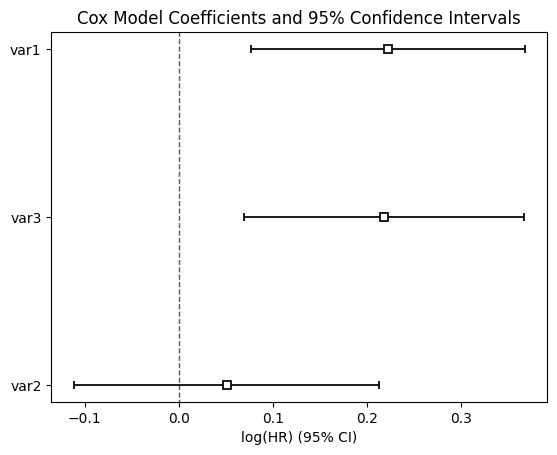


=== Proportional Hazards Assumption Test ===
Proportional hazard assumption looks okay.


[]

In [6]:
# --- Fit Cox Proportional Hazards Model ---
cph = CoxPHFitter()
cph.fit(survival_data_df, duration_col='T', event_col='E')

# --- Print model summary ---
print("\n=== Cox Proportional Hazards Model Summary ===")
cph.print_summary()  # shows coefficients, p-values, confidence intervals, etc.

# --- Interpret the hazard ratios ---
print("\n=== Hazard Ratios (exp(coef)) ===")
print(cph.hazard_ratios_)

# --- Example text interpretation ---
for var, coef in cph.params_.items():
    if coef > 0:
        direction = "increases"
    elif coef < 0:
        direction = "decreases"
    else:
        direction = "does not affect"
    print(f"• A one-unit increase in {var} {direction} the hazard rate (coef={coef:.3f}).")

# --- Plot the coefficients with confidence intervals ---
cph.plot()
plt.title("Cox Model Coefficients and 95% Confidence Intervals")
plt.show()

# --- Check proportional hazards assumption ---
print("\n=== Proportional Hazards Assumption Test ===")
cph.check_assumptions(survival_data_df, p_value_threshold=0.05, show_plots=False)


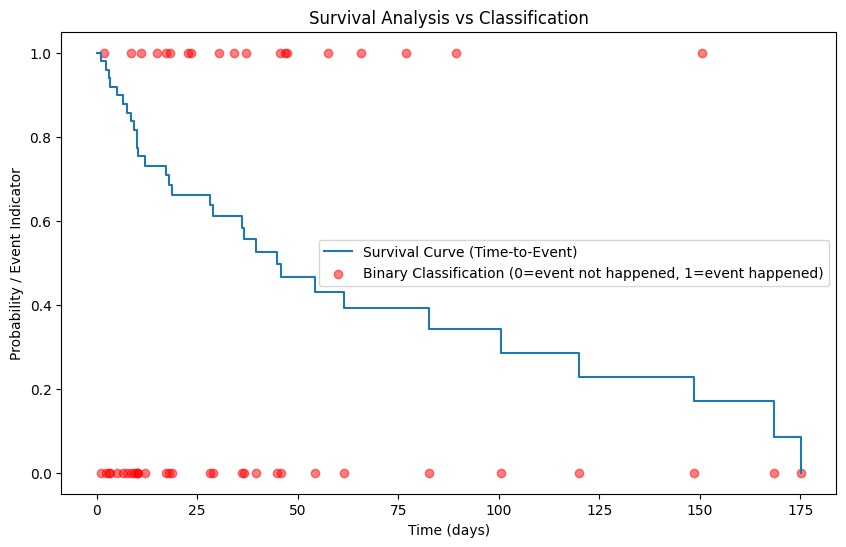

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# --- Simulate example data ---
np.random.seed(42)
n = 50

# Simulate "time until event" (days)
time_until_event = np.random.exponential(scale=50, size=n)

# Randomly censor some observations
censoring = np.random.binomial(1, 0.7, size=n)  # 1 = event observed, 0 = censored
observed_event = censoring

# Binary classification outcome (1 if event observed, 0 if censored)
classification_label = observed_event.copy()

df = pd.DataFrame({
    'T': time_until_event,
    'E': observed_event,
    'Class': classification_label
})

# --- Kaplan-Meier Survival Curve ---
kmf = KaplanMeierFitter()
kmf.fit(durations=df['T'], event_observed=df['E'], label='Survival Probability')

# --- Plot survival curve vs classification ---
plt.figure(figsize=(10,6))
plt.step(kmf.survival_function_.index, kmf.survival_function_['Survival Probability'], where='post', label='Survival Curve (Time-to-Event)')
plt.scatter(df['T'], 1-df['Class'], color='red', alpha=0.5, label='Binary Classification (0=event not happened, 1=event happened)')
plt.xlabel('Time (days)')
plt.ylabel('Probability / Event Indicator')
plt.title('Survival Analysis vs Classification')
plt.legend()
plt.show()
